## Language Detection (of 20,000 Samples)

Dataset Source: https://www.kaggle.com/datasets/basilb2s/language-detection

#### Install Missing & Necessary Libraries

In [1]:
%pip install --upgrade pip
%pip install --upgrade datasets transformers evaluate numpy torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Import Necessary Libraries

In [2]:
import sys, os
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, set_seed
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

import evaluate

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


#### Display Versions of Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.24.2
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1
         Torch: 1.13.1
      Evaluate: 0.4.0


#### Load Dataset

In [4]:
parent_dir = "/Users/briandunn/Desktop/nlp_ds/Language Detect AI Software"

df = pd.read_csv(os.path.join(parent_dir, "language_detection.csv"))

df = df[df["language"] != "Chinese"]
df = df[df["language"] != "Japanese"]
df = df.dropna()

df["Text"] = df["Text"].str.strip()
df["language"] = df["language"].str.strip()

# Change Feature names
df.rename(
    columns={
        "Text": "text", 
        "language": "labels",
        },
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   labels  20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


#### Visualize: Length Text Length (in Words)

The maximum length of this dataset is approximately 331 words.


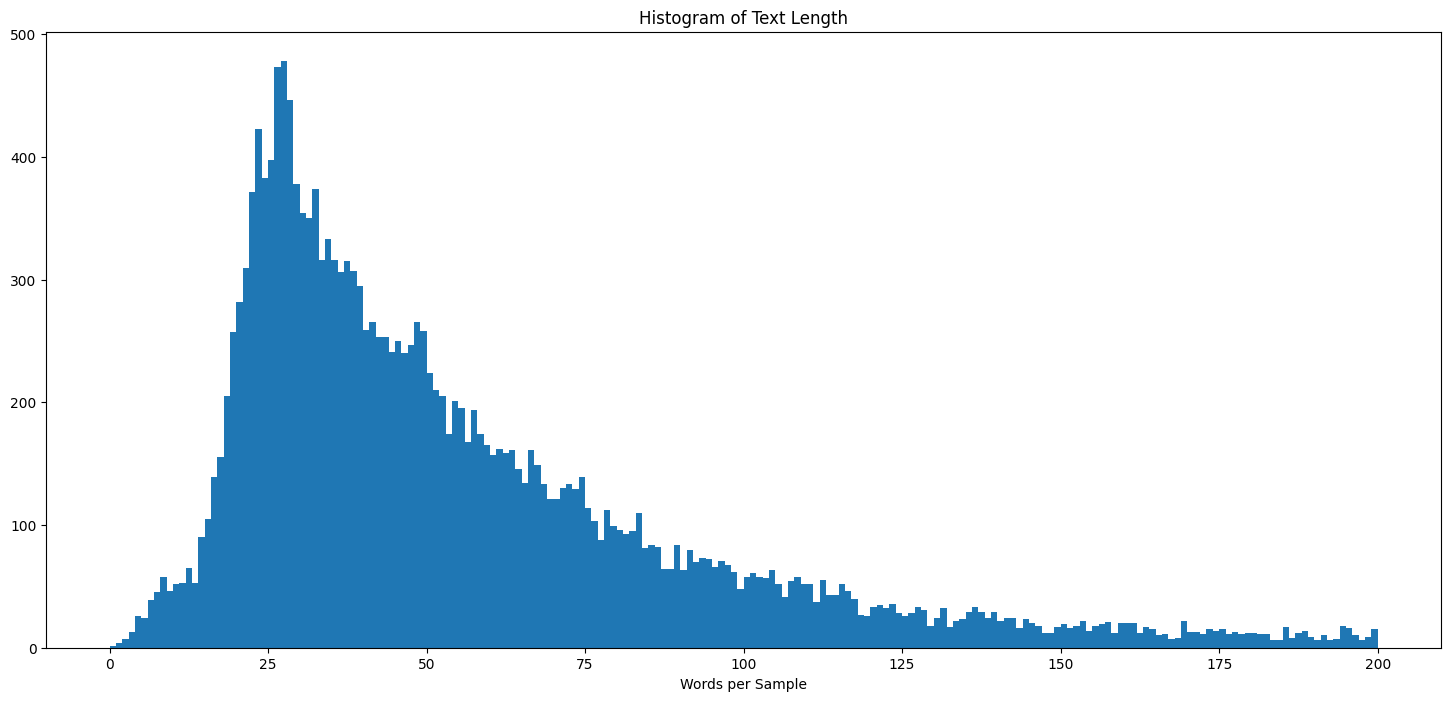

In [5]:
df['Text Length'] = df['text'].str.split().str.len()

max_len = df['Text Length'].max()
print(f"The maximum length of this dataset is approximately {max_len} words.")

n = 200
df.hist('Text Length', grid=False, figsize=(18,8), range=(0, n), bins=n)
plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Sample')
plt.show()

#### Visualize: Length Text Length (in Words) By Language

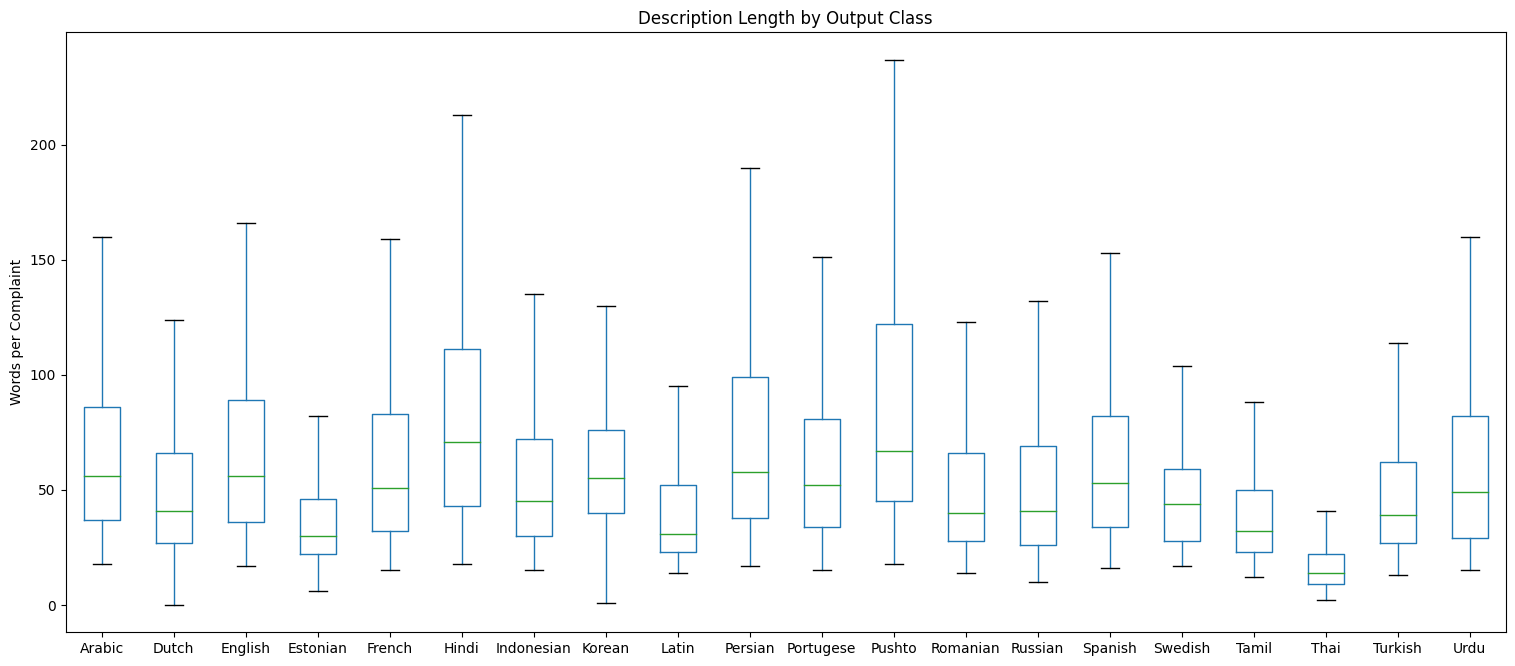

In [6]:
df.boxplot("Text Length", by="labels", grid=False, showfliers=False, figsize=(18, 8))

plt.suptitle('')
plt.title('Description Length by Output Class')
plt.xlabel('')
plt.ylabel('Words per Complaint')
plt.show()

#### Visualize: Number of Samples of Each Language

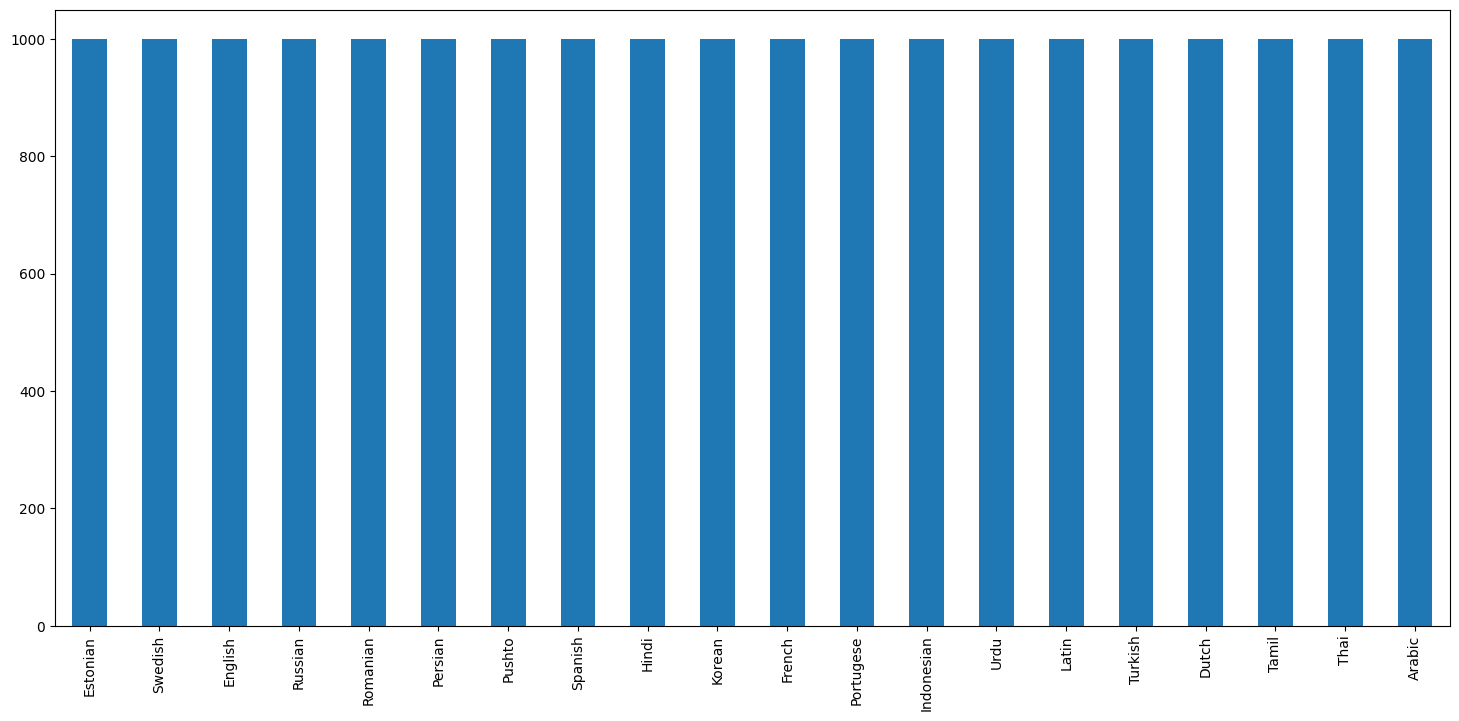

In [7]:
df['labels'].value_counts().plot(kind='bar', figsize=(18, 8))

plt.show()

#### Convert Labels Between String & Integer

In [8]:
LABEL_NAMES = list(set(df['labels']))
NUM_OF_LABELS = len(LABEL_NAMES)

id2label = dict(enumerate(LABEL_NAMES))
label2id = {v: k for k,v in id2label.items()}

print(LABEL_NAMES, '\n', NUM_OF_LABELS)
print("id2label:", id2label)
print("label2id:", label2id)

['Indonesian', 'Spanish', 'Turkish', 'Korean', 'Pushto', 'Estonian', 'French', 'Arabic', 'Urdu', 'Portugese', 'Latin', 'Dutch', 'Thai', 'Hindi', 'Persian', 'Swedish', 'Romanian', 'Russian', 'Tamil', 'English'] 
 20
id2label: {0: 'Indonesian', 1: 'Spanish', 2: 'Turkish', 3: 'Korean', 4: 'Pushto', 5: 'Estonian', 6: 'French', 7: 'Arabic', 8: 'Urdu', 9: 'Portugese', 10: 'Latin', 11: 'Dutch', 12: 'Thai', 13: 'Hindi', 14: 'Persian', 15: 'Swedish', 16: 'Romanian', 17: 'Russian', 18: 'Tamil', 19: 'English'}
label2id: {'Indonesian': 0, 'Spanish': 1, 'Turkish': 2, 'Korean': 3, 'Pushto': 4, 'Estonian': 5, 'French': 6, 'Arabic': 7, 'Urdu': 8, 'Portugese': 9, 'Latin': 10, 'Dutch': 11, 'Thai': 12, 'Hindi': 13, 'Persian': 14, 'Swedish': 15, 'Romanian': 16, 'Russian': 17, 'Tamil': 18, 'English': 19}


#### Final Preprocessing

In [9]:
# Replace String label values with Integer label values
df['labels'].replace(label2id, inplace=True)

# Remove overly lengthy samples
df = df[df["Text Length"] < 200]

# Remove unnecessary Feature
df = df.drop(columns=["Text Length"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19636 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19636 non-null  object
 1   labels  19636 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 460.2+ KB


#### Convert DataFrame to Dataset & Split into Train/Test/Eval Datasets

In [10]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test']
})

print('training data shape:', ds['train'].shape)
print('testing data shape:', ds['test'].shape)
print('validation data shape:', ds['eval'].shape)

training data shape: (15708, 3)
testing data shape: (1964, 3)
validation data shape: (1964, 3)


#### Basic Values/Constants

In [11]:
MODEL_CKPT = "distilbert-base-multilingual-cased"
              
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-language_detection-LG"

DEVICE = torch.device("cpu")
MAX_INPUT_LENGTH = int(220*1.30)

LEARNING_RATE = 2e-5
set_seed(42)

BATCH_SIZE = 64
NUM_OF_EPOCHS = 2

METRIC_NAME = "f1"
WEIGHT_DECAY = 0.01

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

#### Tokenize Entire Dataset

In [12]:
# Define the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Method to Tokenize each Sample in the Dataset
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=MAX_INPUT_LENGTH)

# Map the 'Tokenize' Method to All Samples in the Entire Dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)
encoded_data = encoded_data

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['eval'].shape)
print(encoded_data['train'][24])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

training data shape: (15708, 5)
testing data shape: (1964, 5)
validation data shape: (1964, 5)
{'text': 'bbc  british broadcasting corporation د برتانيې همغاړه خپرندويه ټولنه بي بي سيپه برتانیا کې يوه عمده خپرندویه رسنۍ ده همدا رنگه بي بي سي په نړۍ کې تر ټولو لويه خپرندويه رسنۍ گڼل کېږي دا ټولنه د  شاوخوا کارکوونکي لري د دې تولنې مرکزي ودانۍ په لنډن ښار کې شتون لري  د بي بي سي تر ټولو غټ مسولیت د عامه خلکو لپاره په برتانيا  د چاینل ټاپو او د مېن ټاپو کې خپرنیز چوپړ دی بي بي سي يوه خپل پېيلې autonomous عامه خپرنيزه رسنۍ ده  چې د شاهي قانون تر تگلارې پورې نښتې اداره ده', 'labels': 4, '__index_level_0__': 4243, 'input_ids': [101, 79726, 52676, 15529, 51769, 73063, 771, 100, 100, 770, 49045, 12442, 19077, 10388, 100, 41484, 41484, 37554, 17911, 10388, 12949, 27887, 17317, 100, 793, 37019, 781, 110606, 770, 49045, 12442, 16153, 10388, 100, 40084, 16079, 14914, 42040, 10388, 41484, 41484, 37554, 817, 10388, 100, 100, 54237, 100, 68269, 23505, 770, 49045, 12442, 19077, 10388, 100, 100, 100, 1

#### Instantiate Model

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, 
                                                           num_labels=NUM_OF_LABELS,
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           ).to(DEVICE)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'pre_cla

#### Define Function to Compute Metrics

In [14]:
def compute_metrics(p):
    ### ------------------- Accuracy -------------------
    
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    logging_first_step=True,
    disable_tqdm=False,
    report_to=REPORTS_TO,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Data Collator

In [16]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Instantiate Trainer

In [17]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["eval"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Cloning https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection-LG into local empty directory.


#### Train Model

In [18]:
train_results = trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 15708
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 492
  Number of trainable parameters = 135340052


A Jupyter Widget

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 3.013, 'learning_rate': 1.9959349593495936e-05, 'epoch': 0.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1964
  Batch size = 64


{'loss': 0.7343, 'learning_rate': 1e-05, 'epoch': 1.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection-LG/checkpoint-246
Configuration saved in distilbert-base-multilingual-cased-language_detection-LG/checkpoint-246/config.json


{'eval_loss': 0.11020707339048386, 'eval_accuracy': 0.9882892057026477, 'eval_Weighted F1': 0.9883834269823869, 'eval_Micro F1': 0.9882892057026477, 'eval_Macro F1': 0.9881530019997202, 'eval_Weighted Recall': 0.9882892057026477, 'eval_Micro Recall': 0.9882892057026477, 'eval_Macro Recall': 0.9878939207681052, 'eval_Weighted Precision': 0.9887584896588363, 'eval_Micro Precision': 0.9882892057026477, 'eval_Macro Precision': 0.988708722095916, 'eval_runtime': 367.4798, 'eval_samples_per_second': 5.345, 'eval_steps_per_second': 0.084, 'epoch': 1.0}


Model weights saved in distilbert-base-multilingual-cased-language_detection-LG/checkpoint-246/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection-LG/checkpoint-246/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection-LG/checkpoint-246/special_tokens_map.json
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection-LG/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection-LG/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1964
  Batch size = 64


{'loss': 0.0939, 'learning_rate': 0.0, 'epoch': 2.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection-LG/checkpoint-492
Configuration saved in distilbert-base-multilingual-cased-language_detection-LG/checkpoint-492/config.json


{'eval_loss': 0.08024910092353821, 'eval_accuracy': 0.9882892057026477, 'eval_Weighted F1': 0.9884032779701928, 'eval_Micro F1': 0.9882892057026477, 'eval_Macro F1': 0.9881514725383678, 'eval_Weighted Recall': 0.9882892057026477, 'eval_Micro Recall': 0.9882892057026477, 'eval_Macro Recall': 0.9878939207681052, 'eval_Weighted Precision': 0.9888271933364899, 'eval_Micro Precision': 0.9882892057026477, 'eval_Macro Precision': 0.9887341275097938, 'eval_runtime': 374.6062, 'eval_samples_per_second': 5.243, 'eval_steps_per_second': 0.083, 'epoch': 2.0}


Model weights saved in distilbert-base-multilingual-cased-language_detection-LG/checkpoint-492/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection-LG/checkpoint-492/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection-LG/checkpoint-492/special_tokens_map.json
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection-LG/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection-LG/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-multilingual-cased-language_detection-LG/checkpoint-246 (score: 0.9882892057026477).


{'train_runtime': 21382.9883, 'train_samples_per_second': 1.469, 'train_steps_per_second': 0.023, 'train_loss': 0.41873845724555536, 'epoch': 2.0}


#### Save Model & Training Metrics

In [19]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection-LG
Configuration saved in distilbert-base-multilingual-cased-language_detection-LG/config.json
Model weights saved in distilbert-base-multilingual-cased-language_detection-LG/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection-LG/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection-LG/special_tokens_map.json
Saving model checkpoint to distilbert-base-multilingual-cased-language_detection-LG
Configuration saved in distilbert-base-multilingual-cased-language_detection-LG/config.json
Model weights saved in distilbert-base-multilingual-cased-language_detection-LG/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection-LG/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection-LG/special_tokens_map.json
Several comm

A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection-LG
   d11035a..9591f8d  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9882892057026477}]}
To https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection-LG
   9591f8d..041fff0  main -> main



***** train metrics *****
  epoch                    =        2.0
  train_loss               =     0.4187
  train_runtime            = 5:56:22.98
  train_samples_per_second =      1.469
  train_steps_per_second   =      0.023


#### Evaluate Model

In [20]:
output_metrics = trainer.evaluate()
trainer.log_metrics("eval", output_metrics)
trainer.save_metrics("eval", output_metrics)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1964
  Batch size = 64


A Jupyter Widget

***** eval metrics *****
  epoch                   =        2.0
  eval_Macro F1           =     0.9882
  eval_Macro Precision    =     0.9887
  eval_Macro Recall       =     0.9879
  eval_Micro F1           =     0.9883
  eval_Micro Precision    =     0.9883
  eval_Micro Recall       =     0.9883
  eval_Weighted F1        =     0.9884
  eval_Weighted Precision =     0.9888
  eval_Weighted Recall    =     0.9883
  eval_accuracy           =     0.9883
  eval_loss               =     0.1102
  eval_runtime            = 0:06:03.76
  eval_samples_per_second =      5.399
  eval_steps_per_second   =      0.085


#### Push Fine-Tuned Model to HuggingFace Hub (My Profile!!!)

In [21]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection-LG
Configuration saved in distilbert-base-multilingual-cased-language_detection-LG/config.json
Model weights saved in distilbert-base-multilingual-cased-language_detection-LG/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection-LG/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection-LG/special_tokens_map.json
remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection-LG
   041fff0..02cf9e5  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9882892057026477}]}
To https://huggingface.co/DunnBC22/distilbert-base-mult

'https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection-LG/commit/02cf9e554e489643d85d1dd8cb0416d4d64bdb3b'

### Notes & Other Takeaways From This Projects
****
- Again, another fantastic result!
- I removed the Chinese and Japanese language samples as they were far longer than the samples for the other 16 languages. This was done to keep the training time as reasonable as possible.
****


### Citations

- Model Checkpoint
    - @article{Sanh2019DistilBERTAD,
  title={DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter},
  author={Victor Sanh and Lysandre Debut and Julien Chaumond and Thomas Wolf},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.01108}
}